# The Reuters Dataset

---

### Colab Note

Don't forget that you can link your notebook to your drive and save your work there. Then you can download and backup your models, reload them to keep training them, or upload datasets to your drive. 

```python
import os
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/') # 'My Drive' is the default name of Google Drives
    os.listdir()
    
# use os.chdir("my-directory") # to change directory, and
# os.listdir()                 # to list its contents
# os.getcwd()                  # to get the name of the current directory
# os.mkdir("my-new-dir")       # to create a new directory
# See: https://realpython.com/working-with-files-in-python/

# You can also use bash commands directly, preceded by a bang
# !ls
# However, the following will *not* change the Python directory 
# the notebook points to (use os.chdir for that)!
# !cd my-directory    
```

---

## 1. Practice

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

### For reproducible results

In Keras ([source](https://keras.io/examples/keras_recipes/reproducibility_recipes/)):
```python
keras.utils.set_random_seed(812) # See below

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()
```

Note: `keras.utils.set_random_seed` will do the following ([source](https://github.com/keras-team/keras/blob/d66ecf029e4864eeeff7e22408e82c95d63422d0/keras/src/utils/rng_utils.py#L58)):

```python
import random
random.seed(42)

import numpy as np
np.random.seed(42)

# if tf as backend
tf.random.set_seed(42)

# if torch as backend
torch.manual_seed(42)
```

In [2]:
keras.utils.set_random_seed(42)

### Dataset processing & model building

In [3]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# load
(train_data, train_labels), (test_data, test_labels) = keras.datasets.reuters.load_data(num_words=10000)

# preprocess
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

one_hot_train_labels = keras.utils.to_categorical(train_labels)
one_hot_test_labels = keras.utils.to_categorical(test_labels)

# split training set into train & validation
partial_x_train=x_train[1000:]
partial_y_train=one_hot_train_labels[1000:]
x_val=x_train[:1000]
y_val=one_hot_train_labels[:1000]

In [4]:
# build
model = keras.models.Sequential()
model.add(keras.Input((10000,)))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(46, activation = 'softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1767445733.695380 2681078 service.cc:152] XLA service 0x600000c85800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767445733.695398 2681078 service.cc:160]   StreamExecutor device (0): Host, Default Version


### Baselines

1) Do you remember the baseline discussion in the lecture? You can import the code and test it here.

In [5]:
attempts = []
for test in test_labels: # ↓ a random number between 0 and 45
    attempts.append(np.random.randint(46) == test)
print(np.mean(attempts))

0.016918967052537846


However, this is insufficient, as the Reuters dataset is imbalanced, and some classes more prevalent than others. In this case, our baseline is the accuracy obtained when **predicting the most prevalent/likely class**:

In [6]:
# Note: we could also use a counter:
from collections import Counter
c = Counter(test_labels)
indx = c.most_common(n=1)[0][0] # ← you could ask for the n most common items

# a plain loop will give us the same result
attempts = []
for test in test_labels: # only predict the most prevalent class
    attempts.append(indx == test)
print(f"The accuracy baseline to beat (if we predict the most prevalent class):", np.mean(attempts))

The accuracy baseline to beat (if we predict the most prevalent class): 0.3619768477292965


We can see that an accuracy of `0.3619768477292965`, the probability of the likeliest class, is higher than the random guess (this is always the case).

2) Sanity check, how does our network perform before training (use `.evaluate` on `partial_x_train, partial_y_train`). Is the accuracy a value you would expect?

In [7]:
results = model.evaluate(x_test, one_hot_test_labels, verbose=0) # our untrained model
print(f"test loss: {results[0]}, test accuracy: {results[1]}")

test loss: 3.8176450729370117, test accuracy: 0.021816562861204147


I0000 00:00:1767445733.924674 2681500 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In this case it is even worse than the random guess!

### Training

In [8]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val,y_val)
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4062 - loss: 3.2052 - val_accuracy: 0.5400 - val_loss: 2.3751
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6154 - loss: 1.8921 - val_accuracy: 0.6530 - val_loss: 1.6011
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7103 - loss: 1.3565 - val_accuracy: 0.7060 - val_loss: 1.3210
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7653 - loss: 1.0737 - val_accuracy: 0.7460 - val_loss: 1.1732
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8126 - loss: 0.8653 - val_accuracy: 0.7670 - val_loss: 1.0751
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8550 - loss: 0.6897 - val_accuracy: 0.7930 - val_loss: 0.9965
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8881 - loss: 0.5397 - val_accuracy: 0.8100 - val_loss: 0.9372
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9132 - loss: 0.4178 - val_accuracy: 0.8200 - val_loss

### Visualise your results

Import `matplotlib` code to visualise the result of your experiments (from lab 3 or the lectures).

Can you think of ways to make the code easy to reuse (when running several experiments)?

As usual, we are after the epoch where best *validation* result (accuracy) has been achieved. Can you think of a way to retrieve that optimal epoch programmatically?

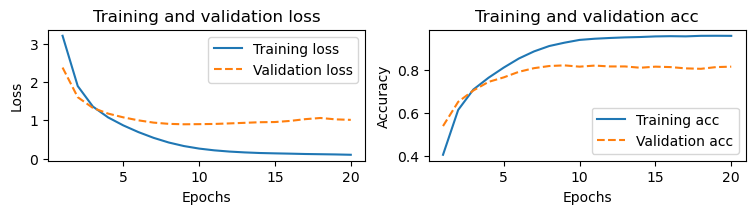

In [9]:
def plot_history(history):
    history_dict = history.history
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]    
    epochs = range(1, len(loss) + 1)
    
    # plot loss and acc horizontally
    fig, axs = plt.subplots(1, 2, figsize=(9,1.7)) 
    axs[0].plot(epochs, loss, label="Training loss")
    axs[0].plot(epochs, val_loss, "--", label="Validation loss")
    axs[0].set_title("Training and validation loss", fontsize=12)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(epochs, acc, label="Training acc")
    axs[1].plot(epochs, val_acc, "--", label="Validation acc")
    axs[1].set_title("Training and validation acc", fontsize=12)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()    
    
    plt.show()
    
plot_history(history)

In [10]:
best_acc_epoch = np.argmax(history.history["val_accuracy"])
best_acc = history.history["val_accuracy"][best_acc_epoch]

print(f"The best validation accuracy, {best_acc} was reachded at epoch {best_acc_epoch}.")

The best validation accuracy, 0.8230000138282776 was reachded at epoch 8.


### Experiments

- Plot training and validation loss and accuracy. Can you spot the optimal epoch (where the best *validation accuracy* has been achieved)?
- Deliberately cause an information bottleneck by building a 64-4-46 network. Compare the validation accuracy with a 64-64-46 network;
- Try using larger layers – 128 units and smaller layers – 32 units;
- Try less and more hidden layers;
- Tabulate your results / organise your experiments as much as you can.

The process of collecting the best accuracy data manually proved to be quite tedious, when working on MNIST. Here instead, I will implement **grid search** again, for various parameters. I will also restrict my search to smaller models and fewer epochs, as a proof of concept, and so that my experiment cycle is faster.

In [11]:
def plot_history(history):
    history_dict = history.history
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]    
    epochs = range(1, len(loss) + 1)
    
    # plot loss and acc horizontally
    fig, axs = plt.subplots(1, 2, figsize=(9,1.7)) 
    axs[0].plot(epochs, loss, label="Training loss")
    axs[0].plot(epochs, val_loss, "--", label="Validation loss")
    axs[0].set_title("Training and validation loss", fontsize=12)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(epochs, acc, label="Training acc")
    axs[1].plot(epochs, val_acc, "--", label="Validation acc")
    axs[1].set_title("Training and validation acc", fontsize=12)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()    
    
    plt.show()

# plot_history(history) # test with the first model

In [12]:
def trainer(layers, optimizer, lr, epochs=10, mode="experiment", clear=True):
    """
    Trainer with two modes:
     - "experiment" (partial train + val)
     - "final" (train + no val)

    returns:
        model, history
    """
    if clear:
        keras.backend.clear_session()
    opt = optimizer(lr) # instatiate the optimizer (so we can retrieve its name, hehe)
    print(f"Training model with:")
    print(f" - {len(layers)} layer(s) with units: {layers}")
    print(f" - {opt.name}(lr={lr})")
    print(f" - # epochs: {epochs}")
    
    # build
    model = keras.models.Sequential()
    model.add(keras.Input((10000,)))
    for n_units in layers:
        model.add(keras.layers.Dense(n_units, activation="relu"))
    model.add(keras.layers.Dense(46, activation="softmax"))
    
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    if mode == "experiment":
        # save data from training into the 'history' object
        history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=epochs,
            batch_size=128,
            validation_data=(x_val, y_val),
            verbose=0, # no need for all this logging
        )
        model = None # save memory
        
    elif mode == "final":
        # train on the entire training data
        history = model.fit(
            x_train,
            one_hot_train_labels,
            epochs=epochs,
            batch_size=128,
            # no validation
            verbose=0, # no need for all this logging
        )
    return model, history

def best_val_performance(history):
    top_val_acc_epoch = np.argmax(history.history["val_accuracy"])
    top_val_acc = history.history["val_accuracy"][top_val_acc_epoch]
    print()
    print("Results:")
    print(f"Top validation accuracy: {top_val_acc}, reached at epoch: {top_val_acc_epoch}.")
    return top_val_acc, top_val_acc_epoch

#### Experiment 1

- Information bottleneck

Using our set-up, we will replicate the experiment seen in the lecture: firs, we train a model with two layers of $64$ units.

Training model with:
 - 2 layer(s) with units: [64, 64]
 - adam(lr=0.001)
 - # epochs: 10

Results:
Top validation accuracy: 0.8209999799728394, reached at epoch: 8.


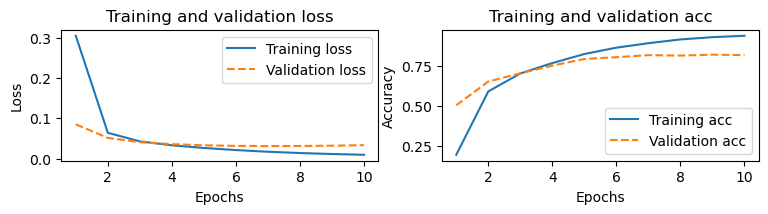

In [13]:
layers = [64,64]
opt = keras.optimizers.Adam
lr = 0.001
_, hist = trainer(layers, opt, lr)
_ = best_val_performance(hist)
plot_history(hist)

The performance increases relatively smoothly, and we only start overfitting at epoch 8.

Now, we can create a bottleneck by having a second layer with far fewer units ($4$):

Training model with:
 - 2 layer(s) with units: [64, 4]
 - adam(lr=0.001)
 - # epochs: 10

Results:
Top validation accuracy: 0.628000020980835, reached at epoch: 9.


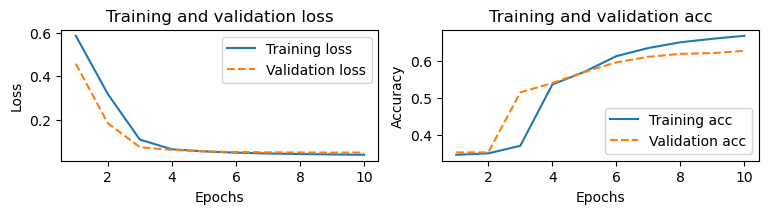

In [14]:
layers = [64, 4]
opt = keras.optimizers.Adam
lr = 0.001
_, hist = trainer(layers, opt, lr)
_ = best_val_performance(hist)
plot_history(hist)

The performance degrades very significantly, to only $63\%$ accuracy! Also, the accuracy progression does not behave as expected, with a jump between epochs 2 and 4!, followed by relative stagnation at this accuracy level.

#### Experiment 2

- Grid search with a hand-made tuner

In [15]:
from itertools import product

def tuner():
    units = [8,12,16]
    layers = [1,2,3]
    # construct layers: e.g. 2 * [8] = [8, 8] in Python
    model_layers = [l * [u] for l, u in list(product(layers, units))]
    optimizers = [keras.optimizers.Adam, keras.optimizers.Adam]
    learning_rates = [0.001, 0.002, 0.003]   

    # TODO: try use a dictionary instead
    all_histories = []
    all_accs = []
    all_accs_epochs = []
    all_params = []
    for layers in model_layers:
            for opt in optimizers:
                for lr in learning_rates:
                    # train our model
                    _, hist = trainer(layers, opt, lr, epochs=5)
                    # plot the history (TODO: try plot all experiments on one plot?)
                    plot_history(hist)
                    acc, acc_epoch = best_val_performance(hist)
                    all_histories.append(hist)
                    all_accs.append(acc)
                    all_accs_epochs.append(acc_epoch)
                    all_params.append({"layers":layers, "opt": opt, "lr": lr})
                    print("-" * 100)
                    print()
                    
    return all_histories, all_accs, all_accs_epochs, all_params

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.001)
 - # epochs: 5


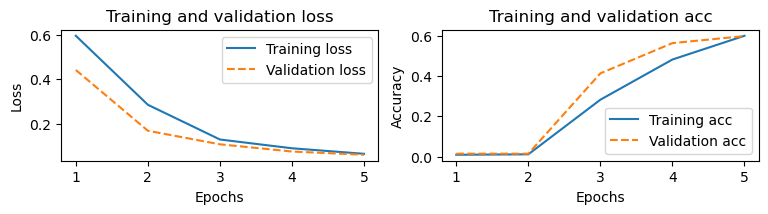


Results:
Top validation accuracy: 0.6010000109672546, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.002)
 - # epochs: 5


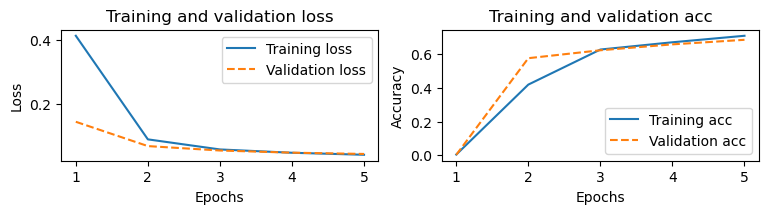


Results:
Top validation accuracy: 0.6859999895095825, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.003)
 - # epochs: 5


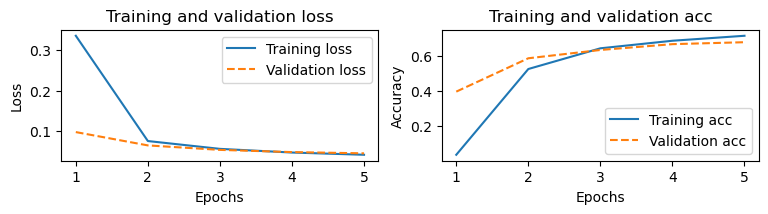


Results:
Top validation accuracy: 0.6759999990463257, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.001)
 - # epochs: 5


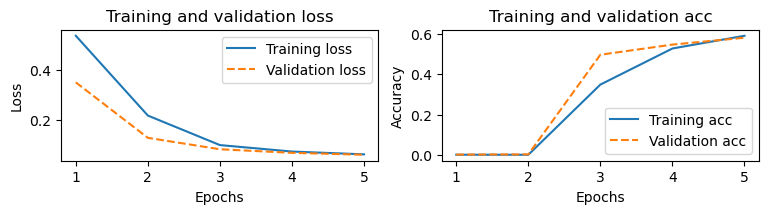


Results:
Top validation accuracy: 0.5799999833106995, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.002)
 - # epochs: 5


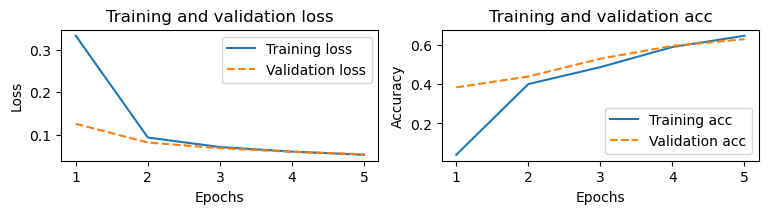


Results:
Top validation accuracy: 0.6269999742507935, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [8]
 - adam(lr=0.003)
 - # epochs: 5


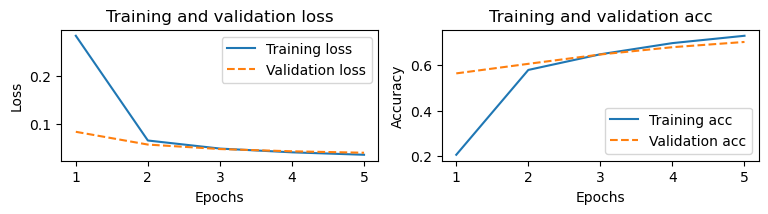


Results:
Top validation accuracy: 0.7009999752044678, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.001)
 - # epochs: 5


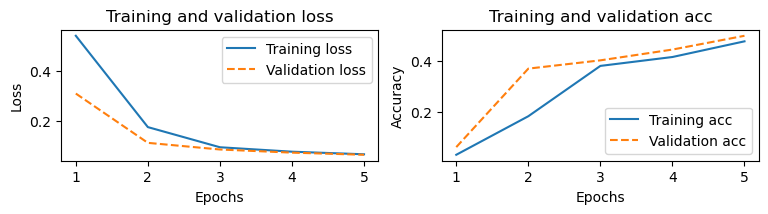


Results:
Top validation accuracy: 0.5019999742507935, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.002)
 - # epochs: 5


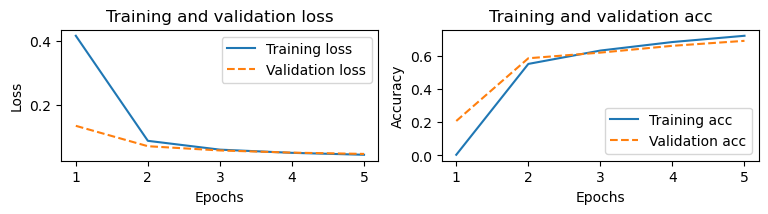


Results:
Top validation accuracy: 0.6909999847412109, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.003)
 - # epochs: 5


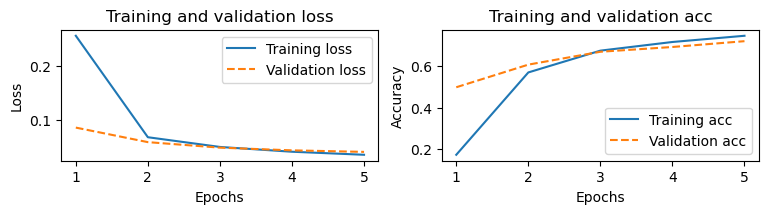


Results:
Top validation accuracy: 0.7200000286102295, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.001)
 - # epochs: 5


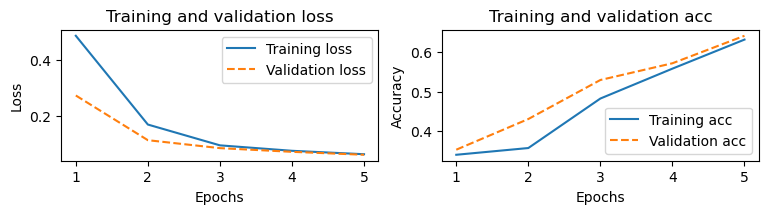


Results:
Top validation accuracy: 0.6399999856948853, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.002)
 - # epochs: 5


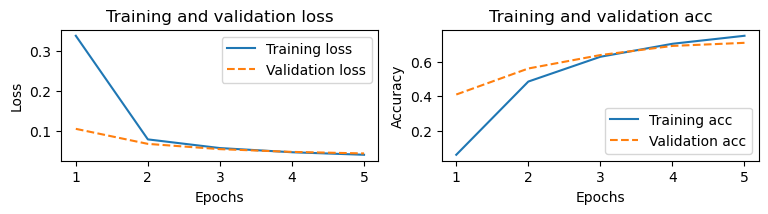


Results:
Top validation accuracy: 0.7089999914169312, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [12]
 - adam(lr=0.003)
 - # epochs: 5


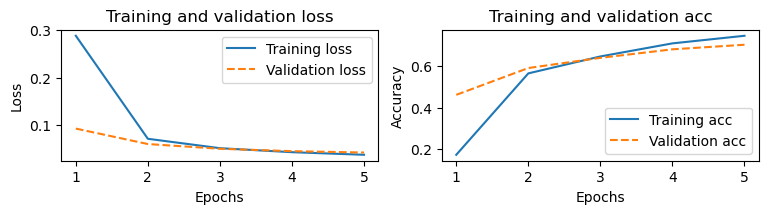


Results:
Top validation accuracy: 0.703000009059906, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.001)
 - # epochs: 5


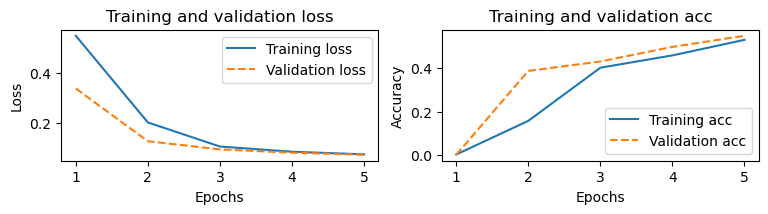


Results:
Top validation accuracy: 0.5490000247955322, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.002)
 - # epochs: 5


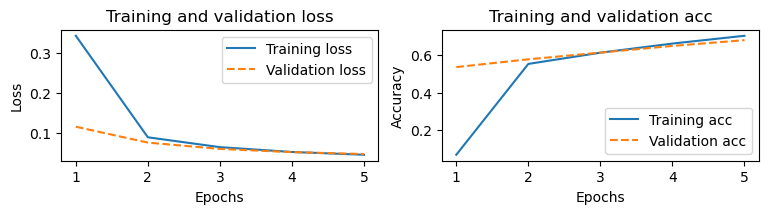


Results:
Top validation accuracy: 0.6819999814033508, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.003)
 - # epochs: 5


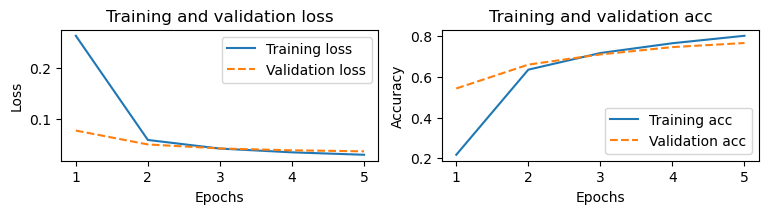


Results:
Top validation accuracy: 0.765999972820282, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.001)
 - # epochs: 5


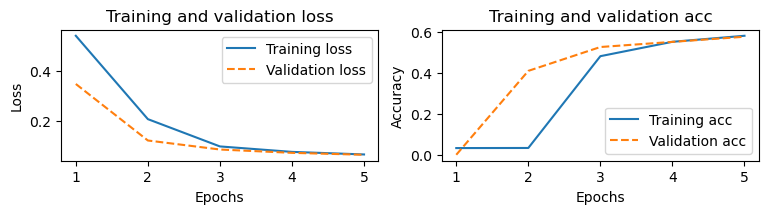


Results:
Top validation accuracy: 0.5770000219345093, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.002)
 - # epochs: 5


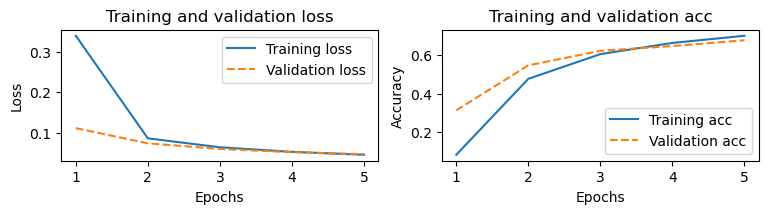


Results:
Top validation accuracy: 0.6759999990463257, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.003)
 - # epochs: 5


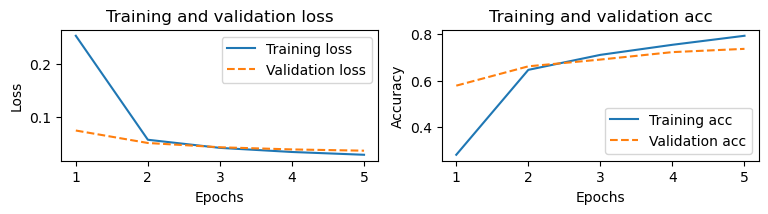


Results:
Top validation accuracy: 0.7369999885559082, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.001)
 - # epochs: 5


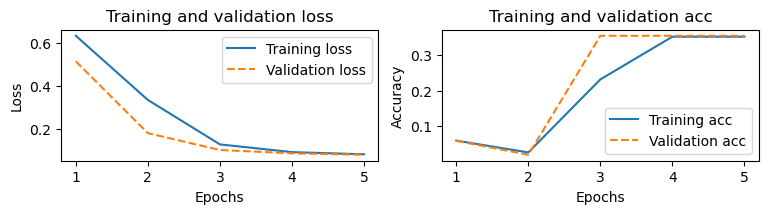


Results:
Top validation accuracy: 0.3540000021457672, reached at epoch: 2.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.002)
 - # epochs: 5


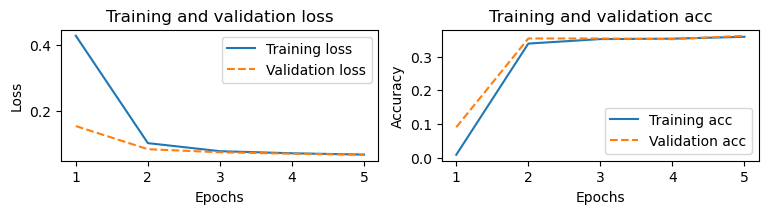


Results:
Top validation accuracy: 0.3619999885559082, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.003)
 - # epochs: 5


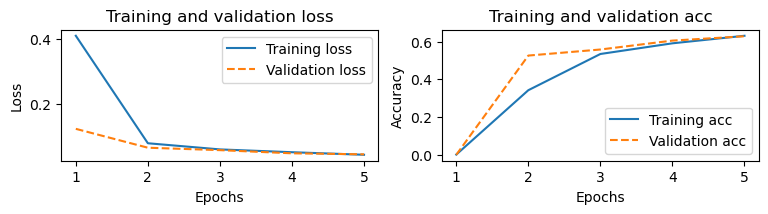


Results:
Top validation accuracy: 0.628000020980835, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.001)
 - # epochs: 5


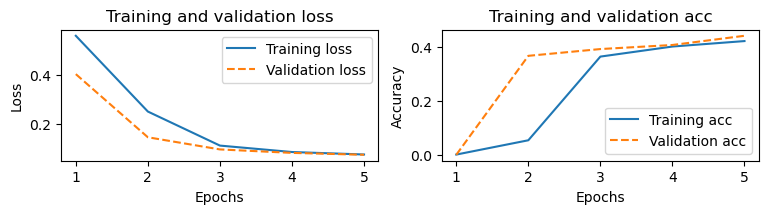


Results:
Top validation accuracy: 0.4399999976158142, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.002)
 - # epochs: 5


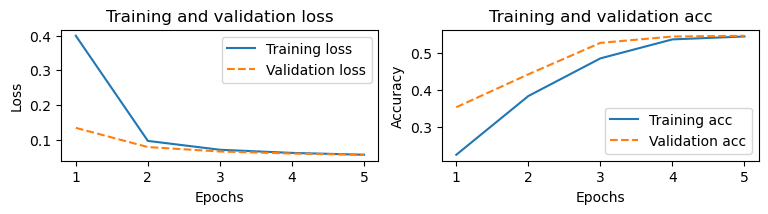


Results:
Top validation accuracy: 0.5450000166893005, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [8, 8]
 - adam(lr=0.003)
 - # epochs: 5


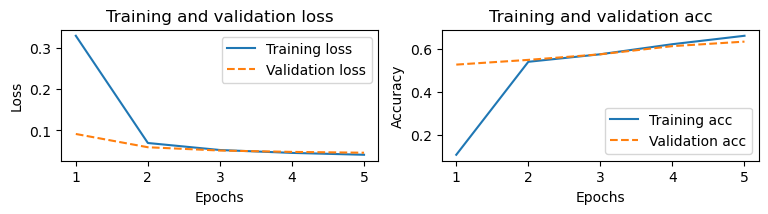


Results:
Top validation accuracy: 0.6349999904632568, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.001)
 - # epochs: 5


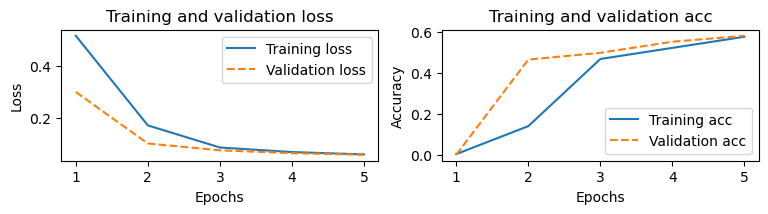


Results:
Top validation accuracy: 0.5799999833106995, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.002)
 - # epochs: 5


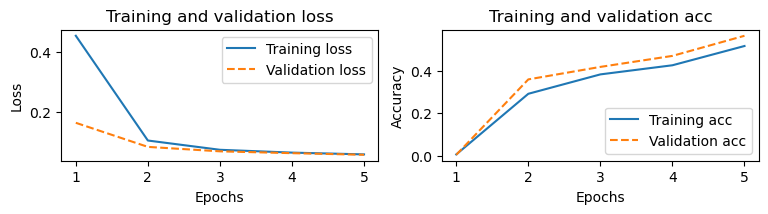


Results:
Top validation accuracy: 0.5659999847412109, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.003)
 - # epochs: 5


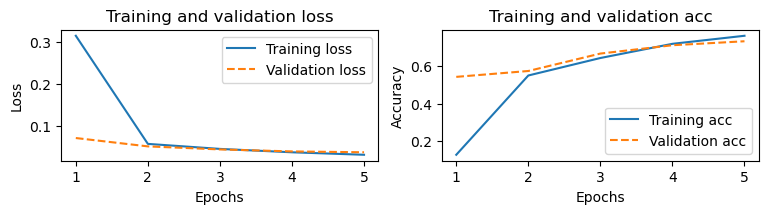


Results:
Top validation accuracy: 0.7289999723434448, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.001)
 - # epochs: 5


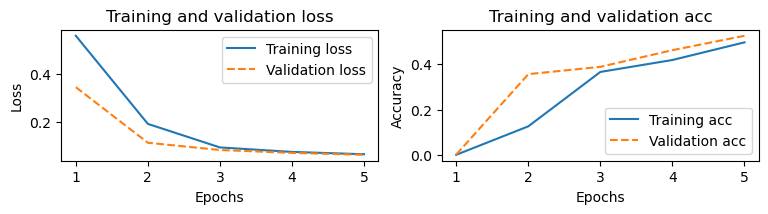


Results:
Top validation accuracy: 0.5230000019073486, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.002)
 - # epochs: 5


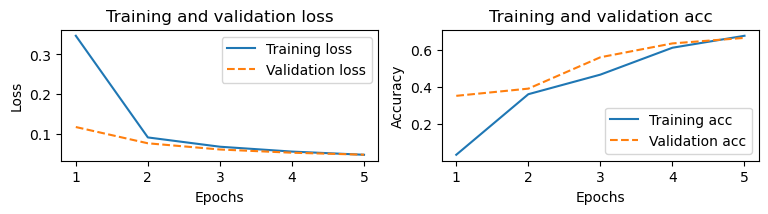


Results:
Top validation accuracy: 0.6679999828338623, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [12, 12]
 - adam(lr=0.003)
 - # epochs: 5


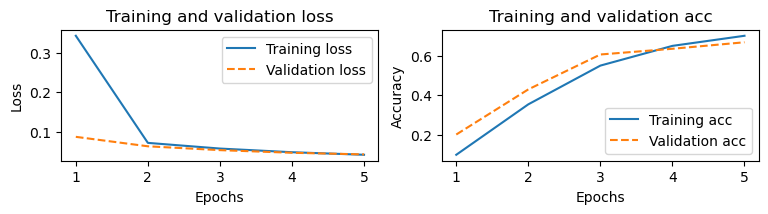


Results:
Top validation accuracy: 0.6690000295639038, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.001)
 - # epochs: 5


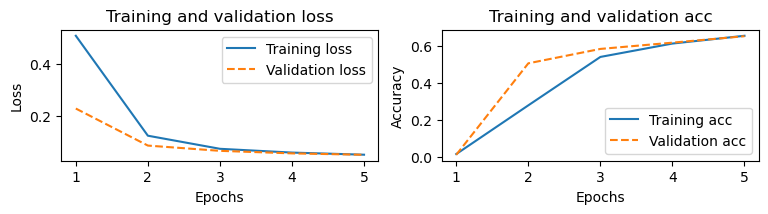


Results:
Top validation accuracy: 0.652999997138977, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.002)
 - # epochs: 5


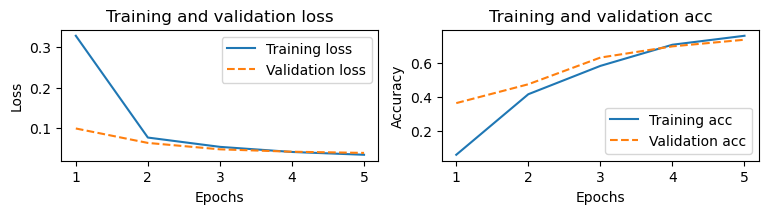


Results:
Top validation accuracy: 0.7379999756813049, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.003)
 - # epochs: 5


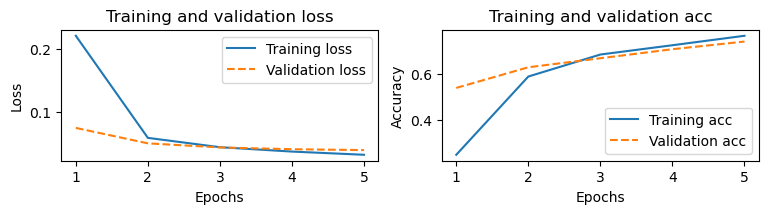


Results:
Top validation accuracy: 0.7379999756813049, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.001)
 - # epochs: 5


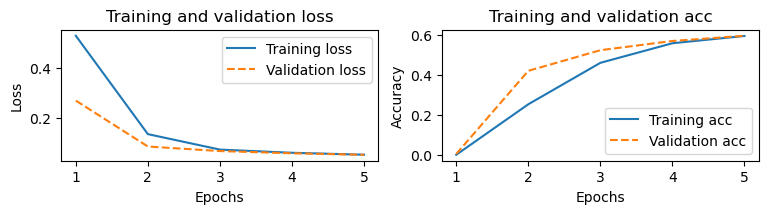


Results:
Top validation accuracy: 0.597000002861023, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.002)
 - # epochs: 5


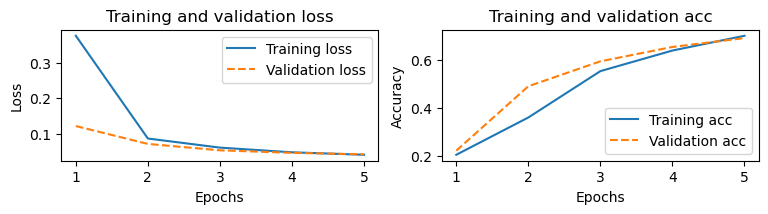


Results:
Top validation accuracy: 0.6919999718666077, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 2 layer(s) with units: [16, 16]
 - adam(lr=0.003)
 - # epochs: 5


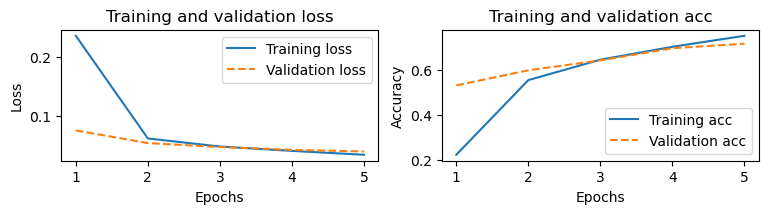


Results:
Top validation accuracy: 0.7179999947547913, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.001)
 - # epochs: 5


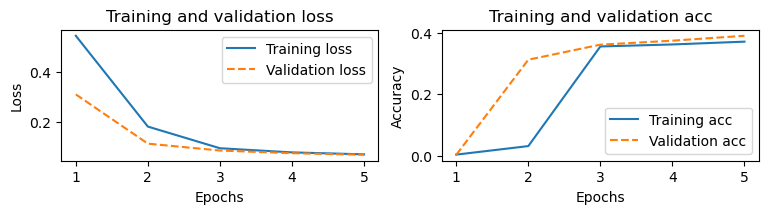


Results:
Top validation accuracy: 0.39100000262260437, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.002)
 - # epochs: 5


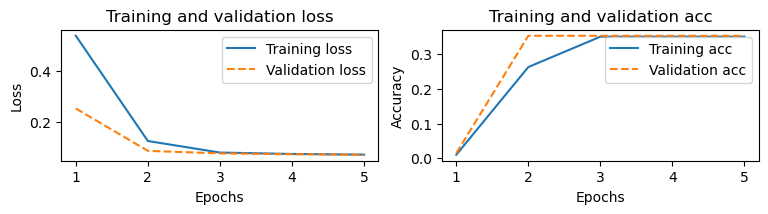


Results:
Top validation accuracy: 0.3540000021457672, reached at epoch: 1.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.003)
 - # epochs: 5


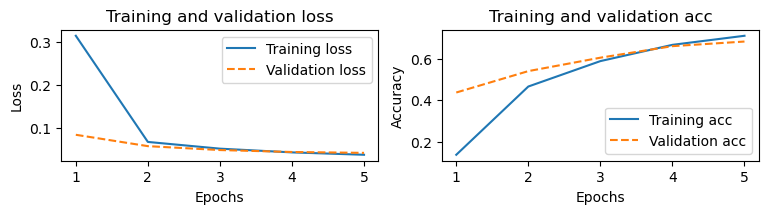


Results:
Top validation accuracy: 0.6809999942779541, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.001)
 - # epochs: 5


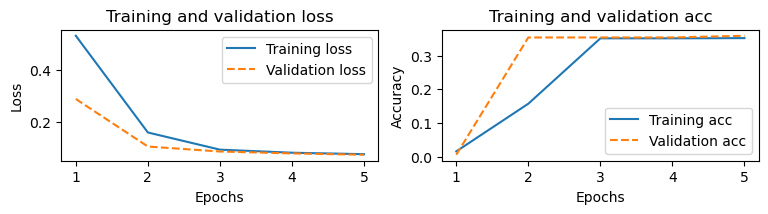


Results:
Top validation accuracy: 0.35899999737739563, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.002)
 - # epochs: 5


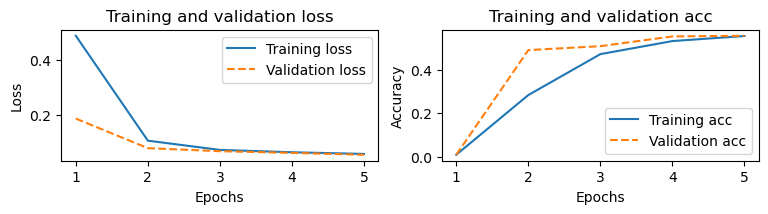


Results:
Top validation accuracy: 0.5569999814033508, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [8, 8, 8]
 - adam(lr=0.003)
 - # epochs: 5


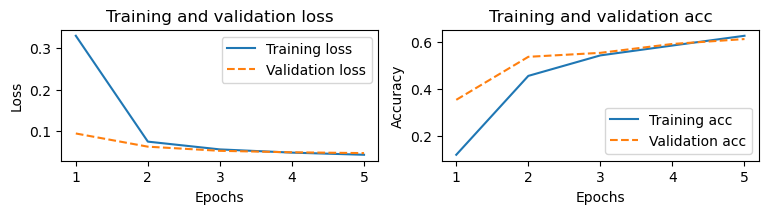


Results:
Top validation accuracy: 0.6140000224113464, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.001)
 - # epochs: 5


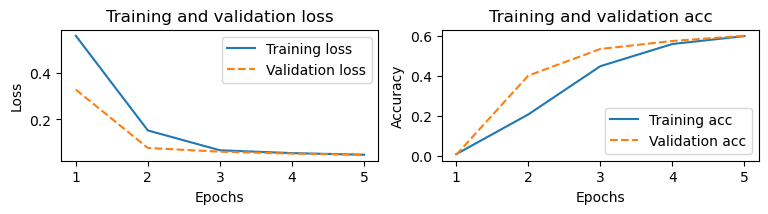


Results:
Top validation accuracy: 0.6000000238418579, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.002)
 - # epochs: 5


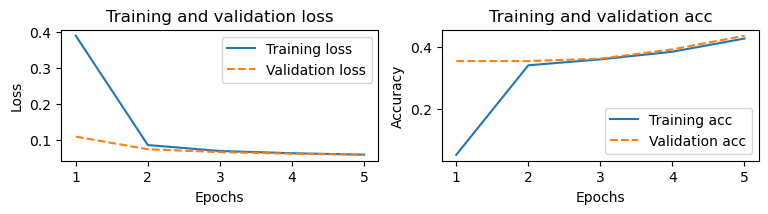


Results:
Top validation accuracy: 0.4359999895095825, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.003)
 - # epochs: 5


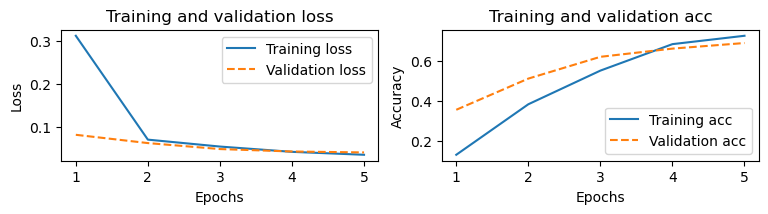


Results:
Top validation accuracy: 0.6880000233650208, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.001)
 - # epochs: 5


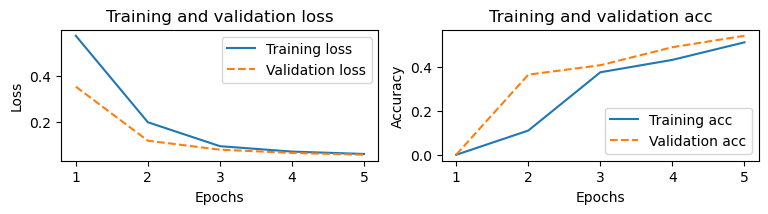


Results:
Top validation accuracy: 0.5440000295639038, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.002)
 - # epochs: 5


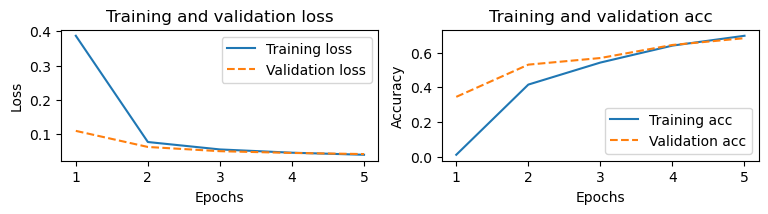


Results:
Top validation accuracy: 0.6830000281333923, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [12, 12, 12]
 - adam(lr=0.003)
 - # epochs: 5


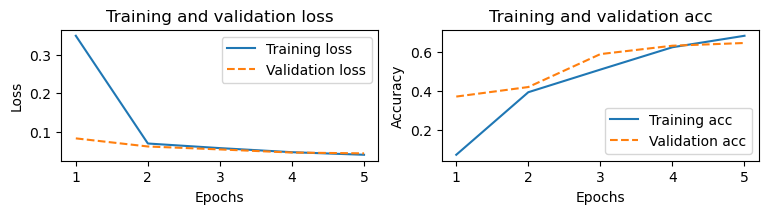


Results:
Top validation accuracy: 0.6470000147819519, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.001)
 - # epochs: 5


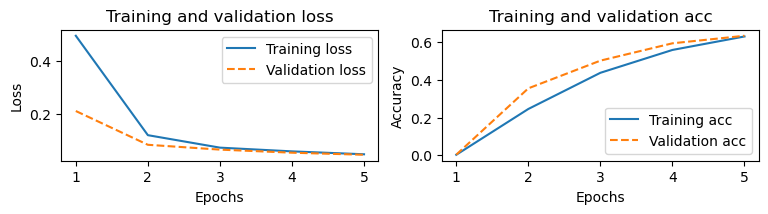


Results:
Top validation accuracy: 0.6340000033378601, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.002)
 - # epochs: 5


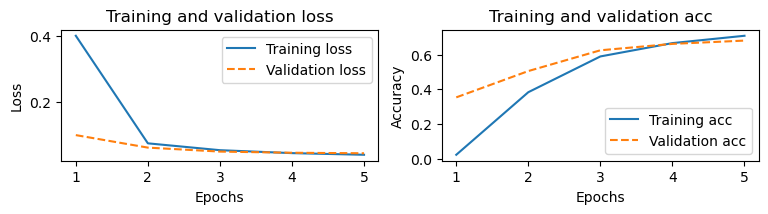


Results:
Top validation accuracy: 0.6819999814033508, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.003)
 - # epochs: 5


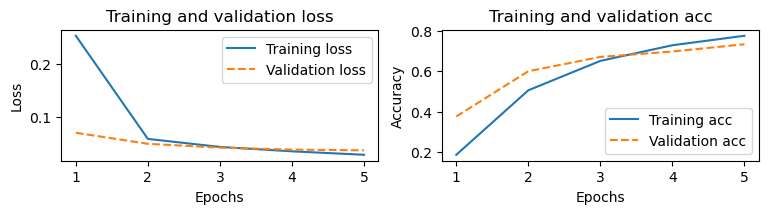


Results:
Top validation accuracy: 0.7350000143051147, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.001)
 - # epochs: 5


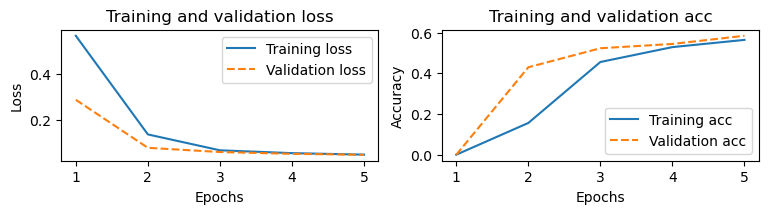


Results:
Top validation accuracy: 0.5839999914169312, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.002)
 - # epochs: 5


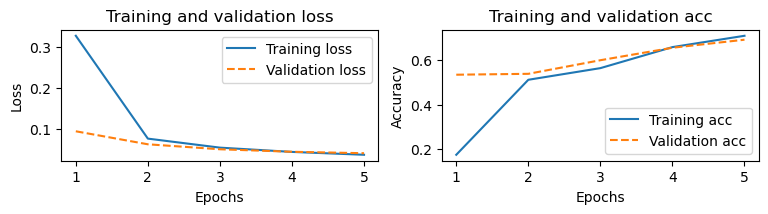


Results:
Top validation accuracy: 0.6909999847412109, reached at epoch: 4.
----------------------------------------------------------------------------------------------------

Training model with:
 - 3 layer(s) with units: [16, 16, 16]
 - adam(lr=0.003)
 - # epochs: 5


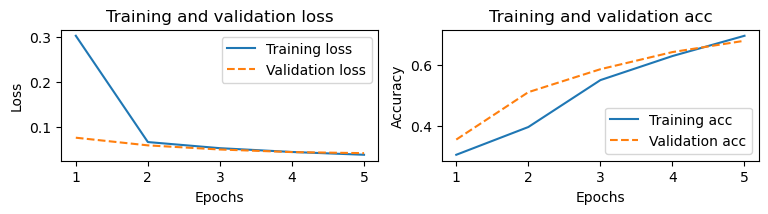


Results:
Top validation accuracy: 0.6779999732971191, reached at epoch: 4.
----------------------------------------------------------------------------------------------------



In [16]:
all_histories, all_accs, all_accs_epochs, all_params = tuner()

In [17]:
all_params[0]

{'layers': [8], 'opt': keras.src.optimizers.adam.Adam, 'lr': 0.001}

In [18]:
def display_experiments(all_histories, all_accs, all_accs_epochs, all_params):
    
    print("-" * 100)
    msg = "Result of this experiment:"
    print(msg)
    print("-" * len(msg))

    longest_l = len(str(max([str(p["layers"]) for p in all_params], key=len)))
    longest_o = len(str(max([p["opt"]().name for p in all_params], key=len)))
    # f-strings in Python: https://www.w3schools.com/python/python_string_formatting.asp
    for acc, epoch, params in zip(all_accs, all_accs_epochs, all_params):
        print(f" - layers: {str(params['layers']):>{longest_l}}, {params['opt']().name:>{longest_o}}(lr={params['lr']}) | top val accuracy: {acc:.6f} at epoch: {epoch}")
    
    # sort my results 
    sorted_indz = np.argsort(all_accs)

    # select the the best one
    best_acc = np.array(all_accs)[sorted_indz][-1]
    best_epoch = np.array(all_accs_epochs)[sorted_indz][-1]
    best_params = np.array(all_params)[sorted_indz][-1]
    
    print()
    print("-" * 100)
    msg = "Best model found:"
    print(msg)
    print("-" * len(msg))
    print(f"Validation accuracy: {best_acc} reached at epoch: {best_epoch}")
    print("Hyperparameters:")
    print(f" - {best_params['layers']} layers")
    print(f" - {best_params['opt']().name}(lr={best_params['lr']})")
    print("-" * len(msg))

    return best_params, best_epoch

In [19]:
best_params, best_epoch = display_experiments(all_histories, all_accs, all_accs_epochs, all_params)

----------------------------------------------------------------------------------------------------
Result of this experiment:
--------------------------
 - layers:          [8], adam(lr=0.001) | top val accuracy: 0.601000 at epoch: 4
 - layers:          [8], adam(lr=0.002) | top val accuracy: 0.686000 at epoch: 4
 - layers:          [8], adam(lr=0.003) | top val accuracy: 0.676000 at epoch: 4
 - layers:          [8], adam(lr=0.001) | top val accuracy: 0.580000 at epoch: 4
 - layers:          [8], adam(lr=0.002) | top val accuracy: 0.627000 at epoch: 4
 - layers:          [8], adam(lr=0.003) | top val accuracy: 0.701000 at epoch: 4
 - layers:         [12], adam(lr=0.001) | top val accuracy: 0.502000 at epoch: 4
 - layers:         [12], adam(lr=0.002) | top val accuracy: 0.691000 at epoch: 4
 - layers:         [12], adam(lr=0.003) | top val accuracy: 0.720000 at epoch: 4
 - layers:         [12], adam(lr=0.001) | top val accuracy: 0.640000 at epoch: 4
 - layers:         [12], adam(lr=0.

Ideas for expansion:
- I focussed on building a small tuner system, rather than experimenting with all possible directions outlined in the brief. This system could be expanded to explore the hyperparameter space in even more detail.
- Given enough time, training for more epochs is likely to improve performance in this case.

## 2. Conclusion

Take your best network and train on **all the training data** (`x_train`, `one_hot_train_labels`), without a train/validation split, using the same hyperparameters (optimizer, learning rate, network size, etc.) as your best run, for the optimal number of epochs (looking at your best validation curves).

In [20]:
best_params, best_epoch

({'layers': [16], 'opt': keras.src.optimizers.adam.Adam, 'lr': 0.003},
 np.int64(4))

In [21]:
model, _ = trainer(
    best_params['layers'],
    best_params['opt'],
    best_params['lr'],
    best_epoch,
    mode="final"
)

Training model with:
 - 1 layer(s) with units: [16]
 - adam(lr=0.003)
 - # epochs: 4


Evaluate this last model on the test set (`x_test, one_hot_test_labels`).

In [22]:
result = model.evaluate(x_test, one_hot_test_labels)
print("Final results:")
print(f"Loss: {result[0]}, accuracy: {result[1]}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7061 - loss: 0.0424
Final results:
Loss: 0.042395755648612976, accuracy: 0.7061442732810974


We managed to reach $0.7061442732810974$, around $70\%$ accuracy, on the test set.

### Use your model (optional) 

Can you import the lecture code used to test the model on a newswire, and see if you agree with its prediction?

AS shown in the lecture, the 46 topics are:
```python
# https://github.com/keras-team/keras/issues/12072
# and here: https://martin-thoma.com/nlp-reuters/
topics = [
    'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
    'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
    'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
    'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
    'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
]
```

In [23]:
def decode_wire(wire):
    """A helper function to decode a wire."""
    word_index = keras.datasets.reuters.get_word_index()
    reverse_word_index = {value:key for key,value in word_index.items()}
    decoded_wire = ' '.join([reverse_word_index.get(i - 3, '?') for i in wire])
    return decoded_wire

def classify_wire(dataset_split, index):
    topics = [
        'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
        'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
        'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
        'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
        'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
    ]
    labels = y_train if dataset_split == "train" else y_test
    dataset = train_data if dataset_split == "train" else test_data
    vectorized_dataset = x_train if dataset_split == "train" else x_test
    predictions = model.predict(vectorized_dataset[index:index+1], verbose=0)[0]
    pred = np.argmax(predictions)
    correct = pred == int(labels[index])
    print(f"predicted: {topics[pred]}, label: {topics[int(labels[index])]} | {'✓' if correct else '✗'}")
    print()
    print(decode_wire(dataset[index]))

In [24]:
for _ in range(5):
    split = np.random.choice(["train", "test"])
    index = np.random.randint(0,100) # improvement: fetch the max of train/test depending on split
    print(f"split: {split}, wire #{index}")
    classify_wire(split, index)
    print()
    print("-" * 100)

split: train, wire #56
predicted: earn, label: earn | ✓

? shr loss five cts vs loss six cts net loss 473 784 vs loss 489 257 revs 268 8 mln vs 81 7 mln avg shrs 9 245 247 vs 8 035 326 year shr loss 17 cts vs loss 20 cts net 1 512 534 vs loss 1 553 592 revs 1 448 310 vs 515 225 avg shrs 8 745 132 vs 7 619 863 reuter 3

----------------------------------------------------------------------------------------------------
split: test, wire #24
predicted: coffee, label: coffee | ✓

? mexico has no intention of leaving the international coffee organization ico in the event of brazil withdrawing from the group the mexican coffee institute ? said the ? said in a statement the ico is an important instrument for ? producers obtain an adequate price mexico currently produces around five mln 60 kilo bags of coffee per year brazil said during a meeting of coffee producers in rio de janeiro over the weekend that it would consider leaving the ico if its export quota was reduced by the organization re

### Save and load models

To save and load models locally, you can use [the high-level API](https://www.tensorflow.org/tutorials/keras/save_and_load):
```python
model.save("my_reuters_model.keras")
```
Later one, to reload it, use:
```python
reloaded_model = keras.models.load_model('my_reuters_model.keras')
```

It is also possible to save not just the model, but also the state of your optimiser, and every variable used during training, using the more involved [checkpoints](https://www.tensorflow.org/guide/checkpoint#create_the_checkpoint_objects).

## 3. Additional experiments

- Like in the IMDB dataset, one parameter you could study is the influence on the vocabulary size on the final results: you might then want to store the vocab size in a variable, and use that instead of the hard-coded `10000` that we have.
- Another line of enquiry is the study of the behaviour of your trained model:
  - Are you able to modify existing wire in a way that changes the initial prediction of your model? (One 'automated' way of doing that would be to remove a certain number of words from the review, and see how performance is impacted by that information loss.)
  - Are you able to create a pipeline where you write your own review, or find one online, transform it into the appropriate format (remove punctuation, turn everything to lower case, convert to an array of integers using the dictionary yielded by `keras.datasets.reuters.get_word_index()` (beware of the shift by 3 induced by the reserved tokens for padding, start of sequence and unknown!), and see what prediction you get for it?

In [25]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
word_index = keras.datasets.reuters.get_word_index()
reverse_word_index = {value:key for key,value in word_index.items()}

In [27]:
word_index = { k:v for k,v in word_index.items() if v <= 10000}
reverse_word_index = {value:key for key,value in word_index.items()}

def process_wire(rev, verbose=False):
    # lower case + + no newlines + no punctuation + split on space
    rev = rev.lower().replace("\n", " ").translate(str.maketrans('', '', string.punctuation)).split(" ")
    if verbose:
        print(rev)
    # 0 for padding, 1 for start of sequence, 2 for unknown
    # adding 3 to the word index to account for the first reserved tokens
    # using `.get()`: if w is not in word_index, use -1+3 = 2: 'unknown'
    rev_encoded = [word_index.get(w, -1) + 3 for w in rev]
    if verbose:
        print(rev_encoded)
        print()
    return rev_encoded

def print_wire(wire_arr, label):
    topics = [
        'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
        'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
        'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
        'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
        'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
    ]
    
    decoded_wire = ' '.join([reverse_word_index.get(i - 3, "?") for i in wire_arr])
    wire_multihot_batch = vectorize_sequences([wire_arr])
    # print(wire_multihot_batch.shape)
    predictions = model.predict(wire_multihot_batch, verbose=0)[0]
    plt.figure(figsize=(10,2))
    plt.bar(range(1, len(topics)+1), predictions)
    plt.xticks(range(1, len(topics)+1), labels=topics, fontsize=8, rotation=90)
    plt.show()
    pred = np.argmax(predictions)
    print(f"Label predicted for manually written wire: {topics[pred]}")
    print()
    print(decoded_wire)

Let's test a few reviews found on the Reuters website. First, one found when searching for "acquisitions":

['', 'us', 'drugmaker', 'abbvie', 'abbvn', 'opens', 'new', 'tab', 'said', 'on', 'monday', 'it', 'will', 'buy', 'aliada', 'therapeutics', 'for', '14', 'billion', 'in', 'cash', 'betting', 'on', 'an', 'experimental', 'alzheimers', 'treatment', 'still', 'in', 'the', 'early', 'stage', 'of', 'development', 'abbvie', 'with', 'a', 'market', 'value', 'of', 'about', 'a', '330', 'billion', 'squared', 'off', 'against', 'at', 'least', 'three', 'other', 'pharmaceutical', 'companies', 'interested', 'in', 'aliada', 'a', 'person', 'familiar', 'with', 'the', 'sale', 'process', 'said', 'abbvie', 'shares', 'closed', 'up', '1', 'on', 'monday', '']
[2, 966, 2, 2, 2, 5702, 73, 2, 8, 21, 918, 16, 33, 264, 2, 2, 13, 187, 35, 7, 197, 2, 21, 42, 2, 2, 2821, 325, 7, 4, 378, 1885, 5, 400, 2, 31, 10, 76, 347, 5, 69, 10, 2343, 35, 2, 410, 112, 28, 602, 109, 100, 4254, 201, 1517, 7, 2, 10, 4333, 9278, 31, 4, 211, 1152, 8, 2, 79, 813, 84, 19, 21, 918, 2]



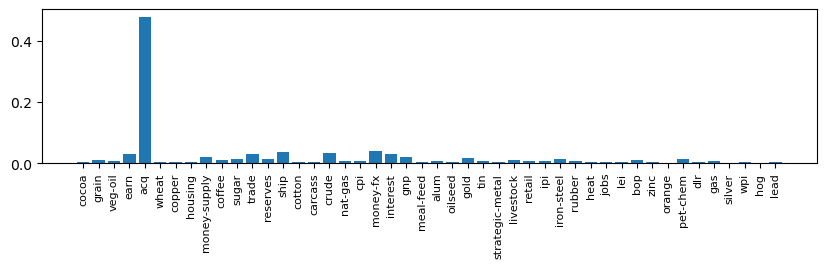

Label predicted for manually written wire: acq

? us ? ? ? opens new ? said on monday it will buy ? ? for 14 billion in cash ? on an ? ? treatment still in the early stage of development ? with a market value of about a 330 billion ? off against at least three other pharmaceutical companies interested in ? a person familiar with the sale process said ? shares closed up 1 on monday ?


In [28]:
# https://www.reuters.com/business/healthcare-pharmaceuticals/abbvie-buy-alzheimers-therapy-developer-aliada-therapeutics-14-bln-2024-10-28/
wire = """
U.S. drugmaker AbbVie (ABBV.N), opens new tab said on Monday it will buy Aliada Therapeutics for $1.4 billion in cash, betting on an experimental Alzheimer's treatment still in the early stage of development.
AbbVie, with a market value of about a $330 billion, squared off against at least three other pharmaceutical companies interested in Aliada, a person familiar with the sale process said. AbbVie shares closed up 1% on Monday.
"""

# testing if the wire is correctly encoded then decoded
print_wire(process_wire(wire, verbose=True), 1)

Remarkable, that seems to have worked!

Next, a rewiew I found by searching "metal feed" on Reuters:

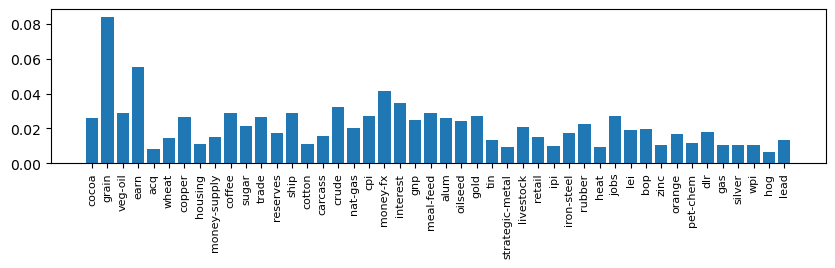

Label predicted for manually written wire: grain

? the may squeeze on the cme copper contract has passed but the impact on global flows of the red metal is still playing out us imports of copper have surged after traders ? on a rare arbitrage window that opened between the cme and the london metal exchange lme contracts at the ? of the squeeze on cme short position holders the result has been a ? of global exchange inventory with cme stocks ? from depleted levels and both lme and shanghai futures exchange ? inventory falling ?


In [29]:
# https://www.reuters.com/markets/commodities/us-copper-imports-accelerate-wake-cme-squeeze-andy-home-2024-10-24/
wire = """
The May squeeze on the CME copper contract has passed but the impact on global flows of the red metal is still playing out.
U.S. imports of copper have surged after traders capitalised on a rare arbitrage window that opened between the CME and the London Metal Exchange (LME) contracts at the height of the squeeze on CME short position holders.
The result has been a redistribution of global exchange inventory with CME stocks rebuilding from depleted levels and both LME and Shanghai Futures Exchange (ShFE) inventory falling.
"""
# testing if the wire is correctly encoded then decoded
print_wire(process_wire(wire), 0)

Surprising and strange... "grain", even if the text talks of copper and metal??

Next, a review I found by searching "housing" on Reuters:

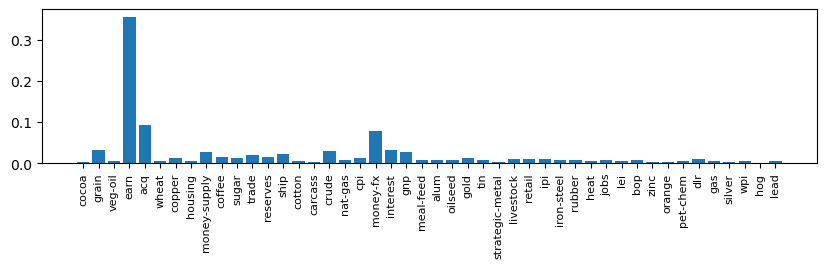

Label predicted for manually written wire: earn

? ? ? opens new ? raised its annual funds from operations forecast on monday ? on ? demand for the healthcare real estate investment trusts ? living and senior housing properties the company now sees its ? ? ? a key performance measure for ? in the range of 427 to 433 per share compared with its previous estimate of 413 to 421 the ? owns housing ? medical centers and healthcare properties with a focus on older ? and ? living it operates in the united states canada and the united kingdom it posted quarterly ? ? of 111 per share an increase of 207 from the previous year ?


In [30]:
# https://www.reuters.com/business/welltower-raises-annual-ffo-forecast-resilient-demand-senior-housing-2024-10-28/
wire = """
Welltower (WELL.N), opens new tab raised its annual funds from operations forecast on Monday, betting on resilient demand for the healthcare real estate investment trust's assisted living and senior housing properties.
The company now sees its 2024 normalized FFO, a key performance measure for REITs, in the range of $4.27 to $4.33 per share, compared with its previous estimate of $4.13 to $4.21.
The REIT owns housing, outpatient medical centers and healthcare properties with a focus on older adults and assisted living. It operates in the United States, Canada and the United Kingdom.
It posted quarterly normalized FFO of $1.11 per share, an increase of 20.7% from the previous year.
"""
# testing if the wire is correctly encoded then decoded
print_wire(process_wire(wire), 0)

Not _quite_ what I expected, but still, predictions are being made!

Let's see if the next one reflects the "oil" search I found it under:

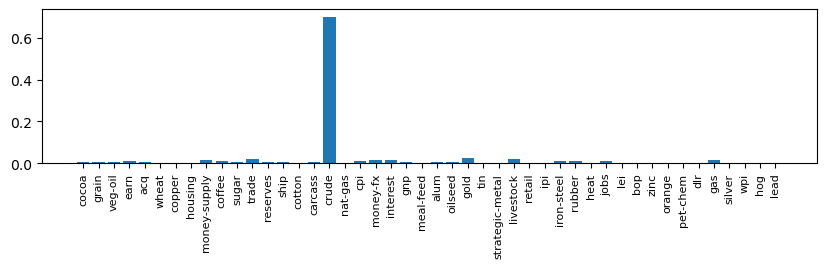

Label predicted for manually written wire: crude

? oil giant petrobras oil output in brazil was down 82 ? in the third quarter to 213 million barrels per day bpd the ? company said on monday petrobras also posted a 65 decrease in total production in the period to 269 million barrels of oil equivalent per day ? output from the firms ? fields an ? offshore region off the ? southeastern atlantic coast fell 27 adding up to a decrease in production on petrobras other fields according to oil giant total sales in the period were down 32 ? to 297 million bpd while exports fell 23 to ? bpd ?


In [31]:
# https://www.reuters.com/markets/commodities/brazils-petrobras-posts-65-fall-q3-total-production-2024-10-28/
wire = """
Oil giant Petrobras' oil output in Brazil was down 8.2% year-on-year in the third quarter, to 2.13 million barrels per day (bpd), the state-controlled company said on Monday.
Petrobras also posted a 6.5% decrease in total production in the period, to 2.69 million barrels of oil equivalent per day (boepd).
Output from the firm's pre-salt fields, an oil-rich offshore region off the country's southeastern Atlantic coast, fell 2.7%, adding up to a decrease in production on Petrobras' other fields.
According to Oil giant, total sales in the period were down 3.2% year-on-year, to 2.97 million bpd, while exports fell 2.3%, to 804,000 bpd.
"""
# testing if the wire is correctly encoded then decoded
print_wire(process_wire(wire), 0)

Ok, looks like crude is crude. It would be a strange game to try and find at least _one_ wire that activates each of those 46 classes...